# Deeperfont
*[Website](http://nbviewer.jupyter.org/github/terryspitz/ipython_notebooks/blob/master/deeperfont.ipynb)*

Deeperfont is a Neural Network attempt at the 'Font Problem' - that is, how to capture the essence of a font in such a way as to generalise to unseen glyphs and to allow interpolation between different fonts.  This problem was noted as early as 1979 when Donald Knuth wrote the first version of [MetaFont](https://en.wikipedia.org/wiki/Metafont).

For this network initial research suggested the use of [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/) as best practise for both getting started and long-term research.  

As output the network will generate a set of [glyph outlines](https://en.wikipedia.org/wiki/Glyph).  The encoding of outputs has been considered in a number of ways: 
* raw (x,y) coordinates, for example as expressed in the [TrueType](https://en.wikipedia.org/wiki/TrueType) font file
* incremental coordinate changes (dx,dy)
* a conversion of these outlines to (angle, distance) pairs for each line as in [Turtle graphics](https://en.wikipedia.org/wiki/Turtle_graphics) (best known for its  use in [Logo](https://en.wikipedia.org/wiki/Logo_(programming_language).)  We do not currently model the bezier curves used in the original glyphs; a future enhancement could use a rendered glyph as the source of font coordinates to train against.

Considering the [loss](https://en.wikipedia.org/wiki/Loss_function) or evaluation function we note that the exact sequence of points in the glyph can be varied while generating identical rendered output, for example a line segment can be split into a number of smaller colinear segments.  The network should be free to express its results in any equivalent way.  The evaluation function is therefore required to compare rendered output.  We build an evaluation function in pure Tensorflow using a [scanline algorithm](https://en.wikipedia.org/wiki/Scanline_rendering) to generate a tensor containing the x coordinates of the outline for a set of equi-spaced y line.  The predicted and true outlines are then compared by calculating the difference in these coordinates (or perhaps *visible pixels* in a future enhancement).

We would like access to the trained glyph outlines but since the network loss function requires the x coordinates we use a final lambda layer to render the outlines for comparison in the loss function, then use the previous, outline generation layer from the fitted model when making predictions.

As input we provide a [one-hot](https://en.wikipedia.org/wiki/One-hot) vector respresenting the individual glyphs to render.  In a future enhancement where we train against multiple fonts, this input could also include a font feature or even font classifications such as serif/sans-serif/script/etc.

See also:
* [MetaFont](https://en.wikipedia.org/wiki/Metafont)
* [Metaflop - interactive MetaFont](http://www.metaflop.com/modulator)
* [deepfont](https://erikbern.com/2016/01/21/analyzing-50k-fonts-using-deep-neural-networks.html)
* https://arxiv.org/abs/1507.03196
* https://pypi.python.org/pypi/FontTools


In [8]:
from enum import Enum
import math
import os
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageDraw, ImageChops, ImageFont
from IPython.display import display
from keras.callbacks import TensorBoard
import keras.models as models
import keras.layers as layers
import keras.initializers
import tensorflow as tf

In [2]:
class Scheme(Enum):
     XY = 1
     DXDY = 2
     ANGDIST = 3

def renderGlyphs(gls, max_points_per_line, ygrid, scheme):
    '''
    Pure tensorflow function
    Input: 2D tensor of glyph * outlines (either x,y or angle, distance pairs)
    Output: glyph * matrix of sorted x coords for each line per y coording
    '''
    if scheme == Scheme.XY:
        xs = gls[:,::2]
        ys = gls[:,1::2]
        visible = tf.logical_or(xs[:,1:]>0,ys[:,1:]>0)
    elif scheme == Scheme.DXDY:
        dxs = gls[:,::2]
        dys = gls[:,1::2]
        xs = tf.cumsum(dxs, axis=-1)+1e-2
        ys = tf.cumsum(dys, axis=-1)+1e-2
        visible = tf.logical_or(xs[:,1:]>0,ys[:,1:]>0)
    elif scheme == Scheme.ANGDIST:
        angles = gls[:,::2]
        dists = gls[:,1::2]
        visible = dists[:,1:]>0
        #turn angles,dists into coordinates
        xs = tf.cumsum(tf.abs(dists)*tf.cos(angles*math.pi), axis=-1)+1e-2
        ys = tf.cumsum(tf.abs(dists)*tf.sin(angles*math.pi), axis=-1)+1e-2
    #offset to create line start x1,y1 to end x2,y2
    x1s = xs[:,:-1]
    x2s = xs[:,1:]
    y1s = ys[:,:-1]
    y2s = ys[:,1:]
    #add 3rd dimension (size=1) so following interpolation in y is broadcast across all lines
    xx1s=tf.expand_dims(x1s,-1)
    xx2s=tf.expand_dims(x2s,-1)
    yy1s=tf.expand_dims(y1s,-1)
    yy2s=tf.expand_dims(y2s,-1)
    #interpolate the x coords for all lines at all y coord
    xxs = xx1s + (xx2s-xx1s)*(ygrid-yy1s)/(yy2s-yy1s)
    #zero x coords outside of line y bounds or where dy=0 and for hidden lines
    in_range = tf.logical_or(tf.logical_and(yy1s<ygrid, ygrid<=yy2s), tf.logical_and(yy2s<ygrid, ygrid<=yy1s))
    in_range = tf.logical_and(in_range, yy2s!=yy1s)
    in_range = tf.logical_and(in_range, tf.expand_dims(visible,-1))
    xxs = tf.where(in_range, xxs, tf.zeros_like(xxs)) 
    return tf.nn.top_k(tf.transpose(xxs, perm=(0,2,1)),max_points_per_line).values

In [3]:
def generateOutlines(glyphs, max_points_per_line, ygrid):
    """
    Read the actual points from all glyphs in the font into numpy array.
    Output is array of glyphs x points x 2 (angle in radians, distance).
    We use float not the original ints from the font - according to https://github.com/fchollet/keras/issues/2218.
    """
    ttx = ET.parse(r'deeper/BASKVILL.ttx') #read font data dumped from TrueType using fonttools
    unitsPerEm = int(ttx.find('head/unitsPerEm').get('value'))*0.9
    def angleDist(p1, p2, hidden=False):
        """Given two point tuples return the angle scaled to [-1,1], and distance scaled similarly"""
        dx = p2[0]-p1[0]
        dy = p2[1]-p1[1]
        return math.atan2(dy,dx)/math.pi, math.sqrt(dx**2 + dy**2) * (-1 if hidden else 1) / unitsPerEm  #negative distance means hidden
    numglyphs = len(glyphs)
    outlines = np.zeros((numglyphs, 200), np.float32)
    Y = np.zeros((numglyphs, len(ygrid),max_points_per_line), np.float32)
    for i, l in enumerate(glyphs):
        glyph = ttx.find(r".//TTGlyph[@name='"+l+"']")
        outline = []
        startp = (0,0.1)
        #ttx contours are areas within the glyph, like the outside and inside outlines of an O
        for contour in glyph.iterfind('contour'):
            pts = contour.iterfind('pt')
            xy = [(int(pt.get('x')), int(pt.get('y'))) for pt in pts] #should read the ttx 'on' attribute too for bezier control points
            #fill output matrix, start with hidden line to start position
            outline += angleDist(startp, xy[0], hidden=True)
            startp = xy[0]
            #then between points
            for n in range(len(xy)-1):
                outline += angleDist(xy[n],xy[n+1])
            #finally wrap last point to first in contour
            N=len(xy)-1
            outline += angleDist(xy[N],xy[0])
        if len(outline)>outlines.shape[1]: print("outline for "+l+" has too many points: ",len(outline))
        outlines[i,:len(outline)] = np.array(outline[:outlines.shape[1]], dtype=np.float32)
    return outlines

def drawOutlines(outlines, cellsize, scheme):
    """Draw numpy array interpreted as a glyph per row and each row containing x,y or angle,dist pairs."""
    columns = math.ceil(800/cellsize)
    rows = math.ceil(outlines.shape[0]/columns)
    def drawPoints(im, points, cellx, celly):
        #temporary image to use to xor each part with main image
        im2 = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
        draw = ImageDraw.Draw(im2) 
        draw.polygon(points, fill=1)
        im = ImageChops.logical_xor(im, im2)
        return im
    scale = cellsize * 0.9
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    for i in range(outlines.shape[0]):
        celly,cellx = divmod(i, columns)
        cellx *= cellsize
        celly *= cellsize
        points = []
        x,y=(0,cellsize-1)
        for j in range(0, outlines.shape[1], 2):
            if scheme == Scheme.XY:
                x = outlines[i][j]*scale
                y = -outlines[i][j+1]*scale
                visible = x>0 or y>0
            elif scheme == Scheme.DXDY:
                x += outlines[i][j]*scale
                y -= outlines[i][j+1]*scale
                visible = x>0 or y>0
            elif scheme == Scheme.ANGDIST:
                angle = outlines[i][j]
                dist = outlines[i][j+1]
                x += abs(dist)*math.cos(angle*math.pi)*scale
                y -= abs(dist)*math.sin(angle*math.pi)*scale
                visible = dist>0
            if visible:
                points += (cellx+x,celly+y)
            elif len(points)>2:
                im = drawPoints(im, points, cellx, celly)
                points=[]
        if len(points)>2:
            im = drawPoints(im, points, cellx, celly)
    return im


def drawXYs(xxs, ygrid, cellsize):
    '''Draw a glyph rasterisation based on a input y coord array with array of x-intercepts of lines with the y coord'''
    columns = math.ceil(800/cellsize)
    rows = math.ceil(xxs.shape[0]/columns)
    scale = cellsize * 0.9
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im) 
    for i in range(xxs.shape[0]):
        yy,xx = divmod(i, columns)
        xx *= cellsize
        yy = (yy+1)*cellsize-1
        for xs, y in zip(xxs[i], ygrid):
            for x in xs:
                if x>0.0:
                    draw.ellipse((xx+x*scale, yy-y*scale, xx+x*scale+3, yy-y*scale+3), fill=1)
    return im

setup...
outline for g has too many points:  204
outline shape:  (62, 200)
output shape:  (62, 20, 10)


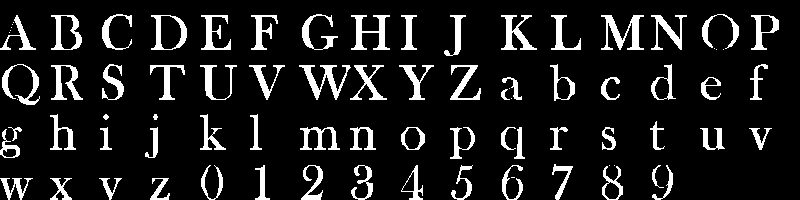

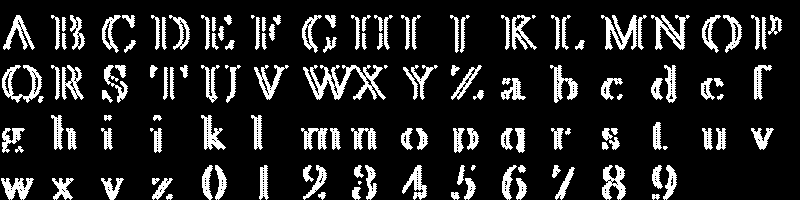

In [4]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
np.set_printoptions(precision=2)
max_points_per_line = 10 # required for g, m
y_divisions = 20
ygrid = np.linspace(0.0, 1.0, y_divisions, endpoint=False) #y coordinates to render on
X = np.identity(len(glyphs), dtype=float)  #input is 'one-hot' array, one per glyph
outlines = generateOutlines(glyphs, max_points_per_line, ygrid)
print("outline shape: ",outlines.shape)
scheme = Scheme.ANGDIST
with tf.Session() as sess:
    xcoords = renderGlyphs(outlines, max_points_per_line, ygrid, scheme).eval()
    #print(xcoords)
    print("output shape: ", xcoords.shape)
cellsize = 50
display(drawOutlines(outlines, cellsize, scheme), drawXYs(xcoords, ygrid, cellsize))

In [5]:
print('compile 2 models...')
model = models.Sequential()
model.add(layers.Dense(100, input_dim=X.shape[1]))
#model.add(LSTM(4))#, return_sequences=True))
#model.add(layers.Dense(100, activation='relu'))
#model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(outlines.shape[1], name='outlines'))
scheme = Scheme.ANGDIST
model.add(layers.Lambda(lambda outline:renderGlyphs(outline, max_points_per_line, ygrid, scheme), name='renderGlyph'))
print("model.output_shape", model.output_shape)
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
#grab a model excluding final rendering layer for fitting/predicting outlines only
outlines_model = models.Model(inputs=model.input, outputs=model.get_layer('outlines').output)
outlines_model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
print("outlines_model.output_shape", outlines_model.output_shape)

compile 2 models...
model.output_shape (None, 20, 10)
outlines_model.output_shape (None, 200)


In [6]:
print('fitting model...')
epochs=1000
logs = 'logs/deeper'
print('tensorboard --logdir='+os.path.abspath('logs'))
board = TensorBoard(log_dir=logs)#, histogram_freq=10000)
outlines_model.fit(X, outlines, batch_size=len(glyphs), epochs=epochs, verbose=0, callbacks=[board])
scores = outlines_model.evaluate(X, outlines, verbose=0)
print("%s: %.2f%%" % (outlines_model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (outlines_model.metrics_names[1], scores[1]*100))
#model.fit(X, xcoords, batch_size=len(glyphs), epochs=1, verbose=0, callbacks=[board])
scores = model.evaluate(X, xcoords, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

fitting model...
tensorboard --logdir=C:\src\Repos\ipython_notebooks\logs
loss: 0.00%
mean_absolute_error: 0.33%
loss: 0.34%
mean_absolute_error: 1.10%


In [ ]:
print('predict outlines...')
outlines_new = outlines_model.predict(X, verbose=0)
print("outlines: ",outlines[0])
print("outlines_new: ",outlines_new[0])
xcoords_new = model.predict(X, verbose=0)
print("xcoords: ",xcoords[0])
print("xcoords_new: ",xcoords_new[0])

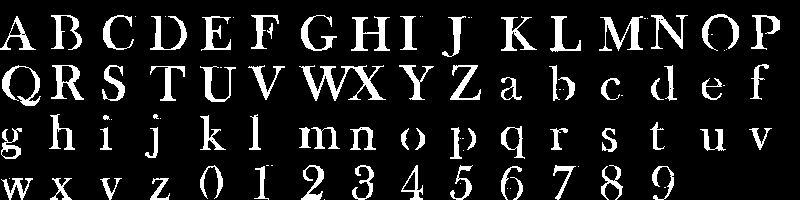

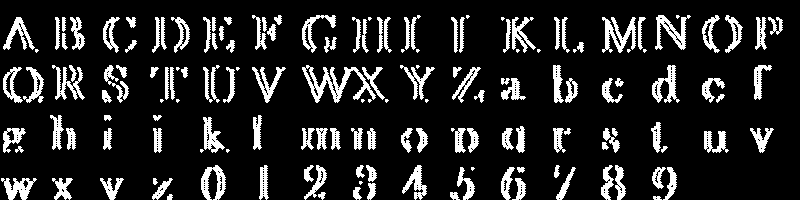

In [9]:
display(drawOutlines(outlines_new, cellsize, scheme), drawXYs(xcoords_new, ygrid, cellsize))

32/62 [==============>...............] - ETA: 0s

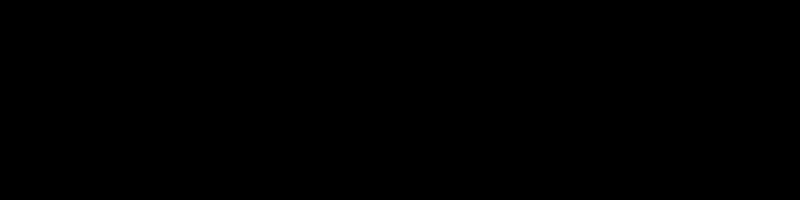

In [16]:
#now, what happens when we predict mixed glyphs?
mixed_outlines = outlines_model.predict(np.random.random(X.shape), verbose=1)
drawOutlines(mixed_outlines, cellsize, scheme)

In [ ]:
#what about interpolating between glyphs?  let's try gradually mixing A into B
#need array [[1, 0, ...], [1, 0.1, ...]]
A = X[0]
B = X[1]
steps=12
mix = np.array([A*(steps-i)/steps + i*B/steps for i in range(steps+1)])
#print(mix[:3])
interp = outlines_model.predict(mix, verbose=1)
drawOutlines(interp)
#not very convincing :(, perhaps raw points rather than angle, dist pairs for the outline would be better
#also need to try interpolating A between two fonts